We need to write a primer for sources of background emission for JWST. 
In preparation, making some illustrative plots.
Draft 27 Sept 2016 by Jane Rigby

In [120]:
import pandas
%pylab
%matplotlib inline
from   scipy.interpolate import interp1d
import jrr
pylab.rcParams['figure.figsize'] = (11, 9)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('axes', linewidth=2)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [42]:
miri_dir = "/Volumes/Apps_and_Docs/WORK/JWST/MIRI_bkgs/"
zodi_dir = "/Volumes/Apps_and_Docs/WORK/JWST/ETC/1.2minzody/"
therm = pandas.read_csv(miri_dir + "thermal_curve_jwst_jrigby_1.1.csv",  comment="#", names=("wave","SB"))
zody =  pandas.read_table(zodi_dir + "zody.summary", delim_whitespace=True, comment="#", names=('wave','d1','d2','SB'))
ism =   pandas.read_table(zodi_dir + "ism.summary",  delim_whitespace=True, comment="#", names=('wave','d1','d2','SB'))
stray_light = pandas.read_table(zodi_dir +  "../WC1.2zody.dat", delim_whitespace=True, comment="#",  names=('wave','SB'))

In [121]:
wave_lo = 0.5  # micron
wave_hi = 30.0 # micron
incr    = 0.1  # micron
wave = np.arange(wave_lo, wave_hi, incr)
total = jrr.spec.rebin_spec_new(zody.wave, zody.SB, wave, fill=0) + \
    jrr.spec.rebin_spec_new(ism.wave, ism.SB, wave, fill=0) + \
    jrr.spec.rebin_spec_new(stray_light.wave, stray_light.SB, wave, fill=0) + \
    jrr.spec.rebin_spec_new(therm.wave, therm.SB, wave, fill=0)

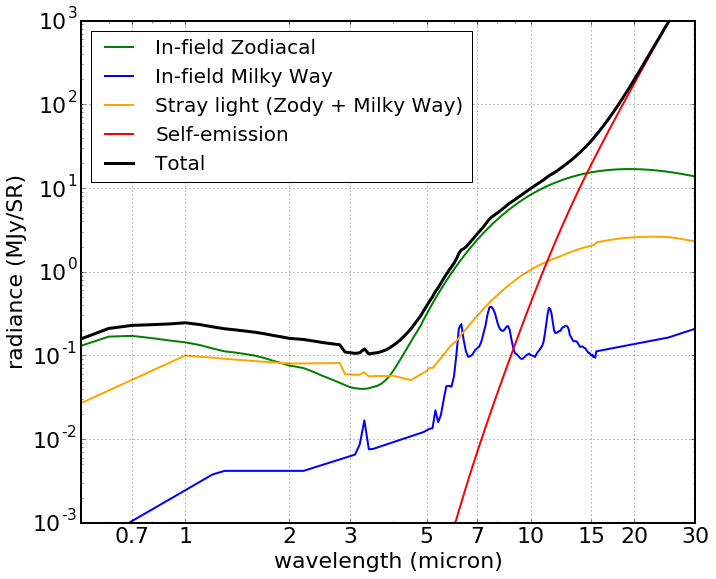

In [125]:
plt.plot(zody.wave, zody.SB, color='green', label="In-field Zodiacal", linewidth=2)
plt.plot(ism.wave,  ism.SB,  color='blue', label="In-field Milky Way", linewidth=2)
plt.plot(stray_light.wave, stray_light.SB, color='orange', label="Stray light (Zody + Milky Way)", linewidth=2)
plt.plot(therm.wave, therm.SB, color='red', label="Self-emission", linewidth=2)
plt.plot(wave, total, label="Total", linewidth=3, color='black')
plt.legend(loc=2, fontsize=20)
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,30)
plt.ylim(1E-3,1E3)
plt.xlabel("wavelength (micron)")
plt.ylabel("radiance (MJy/SR)")
label_x = (0.7,1,2,3,5,7,10,15,20,30)
plt.xticks(label_x, label_x)
plt.savefig('jwst_primer_backgrounds.pdf')